RT-DETR-v2 Train on custom dataset

In [ ]:
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install -q git+https://github.com/roboflow/supervision.git
%pip install -q accelerate
%pip install -q roboflow
%pip install -q torchmetrics
%pip install -q "albumentations>=1.4.5"
%pip install -q torchmetrics[detection]
%pip install -q tensorboard

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mnt/d/Work/coding/vuzz/new/MIREA_7_semester_VT/rsppr/SAFE-MACS/model/rt-detr-v2


In [2]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace

from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

Load model

In [3]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fine-Tune

In [4]:
ROBOFLOW_API_KEY = ('pEbpvVmHCmE4sFlvI8Og')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("safemacsws").project("mppe-custom-set")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 3480
Number of validation images: 288
Number of test images: 287


Data Preprocess

In [6]:
IMAGE_SIZE = 640

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

In [7]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        result = {k: v[0] for k, v in result.items()}

        return result

In [8]:
pytorch_dataset_train = PyTorchDetectionDataset(ds_train, processor)
pytorch_dataset_valid = PyTorchDetectionDataset(ds_valid, processor)
pytorch_dataset_test = PyTorchDetectionDataset(ds_test, processor)

In [9]:
pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.8706, 0.9176, 0.8314,  ..., 0.6784, 0.6706, 0.6588],
          [0.8706, 0.9137, 0.8706,  ..., 0.7176, 0.7059, 0.6902],
          [0.8667, 0.9098, 0.8784,  ..., 0.6588, 0.6588, 0.6627],
          ...,
          [0.7608, 0.8706, 0.7804,  ..., 0.5255, 0.5333, 0.5412],
          [0.8784, 0.8667, 0.7725,  ..., 0.5216, 0.5137, 0.5333],
          [0.8000, 0.8039, 0.8314,  ..., 0.5176, 0.4980, 0.5216]],
 
         [[0.8863, 0.9333, 0.8471,  ..., 0.6784, 0.6706, 0.6588],
          [0.8863, 0.9294, 0.8863,  ..., 0.7176, 0.7059, 0.6902],
          [0.8824, 0.9255, 0.8941,  ..., 0.6588, 0.6588, 0.6627],
          ...,
          [0.7647, 0.8745, 0.7843,  ..., 0.5451, 0.5529, 0.5608],
          [0.8824, 0.8706, 0.7765,  ..., 0.5412, 0.5333, 0.5529],
          [0.8039, 0.8078, 0.8353,  ..., 0.5373, 0.5176, 0.5412]],
 
         [[0.9216, 0.9686, 0.8824,  ..., 0.6863, 0.6784, 0.6667],
          [0.9216, 0.9647, 0.9216,  ..., 0.7255, 0.7137, 0.6980],
          [0.9176, 0.960

Custom data collator

In [10]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

mAP Compute

In [11]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

Train model

In [12]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.

In [13]:
num = int(input())

In [14]:
training_args = TrainingArguments(
    output_dir=f"./rtdetr-v2-L-mppe-{num}",
    num_train_epochs=50,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=8,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="tensorboard",
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    processing_class=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Medical-ppe,Mar 100 Medical-ppe,Map Coverall,Mar 100 Coverall,Map Face Shield,Mar 100 Face Shield,Map Gloves,Mar 100 Gloves,Map Goggles,Mar 100 Goggles,Map Mask,Mar 100 Mask
1,No log,11.924879,0.337700,0.531400,0.361800,0.190400,0.331700,0.468400,0.232200,0.528100,0.574200,0.352600,0.583600,0.768900,-1.000000,-1.000000,0.522500,0.827600,0.049100,0.379600,0.389900,0.575100,0.164600,0.397700,0.562500,0.691000
2,30.585100,11.981927,0.361900,0.586300,0.375100,0.219900,0.370100,0.476300,0.245400,0.534000,0.570200,0.348300,0.572500,0.759000,-1.000000,-1.000000,0.580400,0.840900,0.034000,0.322400,0.433200,0.589100,0.219700,0.419400,0.542200,0.678900
3,12.871600,11.779728,0.382700,0.603600,0.403200,0.228400,0.380600,0.489300,0.252200,0.574700,0.604100,0.367200,0.617000,0.767100,-1.000000,-1.000000,0.604600,0.821800,0.036200,0.451000,0.443400,0.608200,0.277600,0.477900,0.551900,0.661700
4,11.233200,12.903831,0.354000,0.599300,0.353100,0.195600,0.312000,0.507400,0.240200,0.521700,0.569900,0.331700,0.557400,0.746800,-1.000000,-1.000000,0.610400,0.845300,0.062100,0.414300,0.372000,0.537900,0.235900,0.432700,0.489700,0.619400
5,10.482800,12.975452,0.318600,0.551400,0.312700,0.162400,0.282200,0.473800,0.226500,0.501600,0.542800,0.310700,0.528600,0.741800,-1.000000,-1.000000,0.593400,0.834300,0.072600,0.367300,0.382800,0.541400,0.212400,0.430900,0.331800,0.540200
6,9.884200,12.265447,0.377500,0.633900,0.391000,0.234800,0.355900,0.453200,0.259000,0.549200,0.589000,0.363800,0.571800,0.754500,-1.000000,-1.000000,0.638400,0.834500,0.043400,0.389800,0.459800,0.619400,0.287500,0.474200,0.458300,0.627300
7,9.356100,11.543900,0.401700,0.640100,0.421600,0.228900,0.371400,0.532400,0.263700,0.572800,0.606500,0.376300,0.602000,0.787000,-1.000000,-1.000000,0.664800,0.843200,0.069600,0.457100,0.456400,0.619100,0.271800,0.459900,0.546000,0.653300
8,9.356100,12.248806,0.404800,0.667700,0.425100,0.231000,0.376500,0.549300,0.259600,0.565400,0.604200,0.343900,0.607700,0.787200,-1.000000,-1.000000,0.683000,0.831700,0.103000,0.491800,0.446800,0.623300,0.296000,0.453500,0.495000,0.620900
9,9.031300,12.558012,0.391300,0.653000,0.402300,0.216900,0.369500,0.535000,0.269300,0.566800,0.609700,0.366100,0.611200,0.766800,-1.000000,-1.000000,0.659200,0.838900,0.092700,0.508200,0.438100,0.628900,0.278300,0.461300,0.488100,0.611400
10,8.619300,12.191549,0.398600,0.657000,0.419100,0.240600,0.369500,0.526800,0.267200,0.565500,0.610300,0.391000,0.594700,0.768500,-1.000000,-1.000000,0.660000,0.814500,0.083700,0.463300,0.435000,0.653600,0.278300,0.455300,0.536100,0.664900


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=21750, training_loss=7.30797628749102, metrics={'train_runtime': 13956.1749, 'train_samples_per_second': 12.468, 'train_steps_per_second': 1.558, 'total_flos': 5.4826549788672e+19, 'train_loss': 7.30797628749102, 'epoch': 50.0})

In [45]:
targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
from supervision.metrics import F1Score, Precision, Recall

In [88]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)
precision_metric = Precision().update(predictions, targets).compute()
recall_metric = Recall().update(predictions, targets).compute()
f1_metric = F1Score().update(predictions, targets).compute()

print(f"map50_95: {mean_average_precision.map50_95:.3f}")
print(f"map50: {mean_average_precision.map50:.3f}")
print(f"map75: {mean_average_precision.map75:.3f}")
print(f"Precision: {precision_metric.precision_at_50:.3f}")
print(f"Recall: {recall_metric.recall_at_50:.3f}")
print(f"F1 Score: {f1_metric.f1_50:.3f}")

map50_95: 0.563
map50: 0.829
map75: 0.617
Precision: 0.035
Recall: 0.960
F1 Score: 0.067


In [81]:
print(f"F1 Score: {f1_metric.f1_scores} at\nIoU thresholds: {f1_metric.iou_thresholds}")

F1 Score: [0.83246999 0.82080672 0.80366429 0.78682949 0.7552969  0.70577641
 0.62486514 0.52595687 0.3658446  0.14939876] at
IoU thresholds: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


In [98]:
map50_per_class = [iou[0] for iou in mean_average_precision.per_class_ap50_95]

for class_name, map_val in zip(ds_test.classes[1:], map50_per_class):
    print(f'{class_name} - {map_val:.3f}')

Coverall - 0.954
Face_Shield - 0.716
Gloves - 0.838
Goggles - 0.699
Mask - 0.938


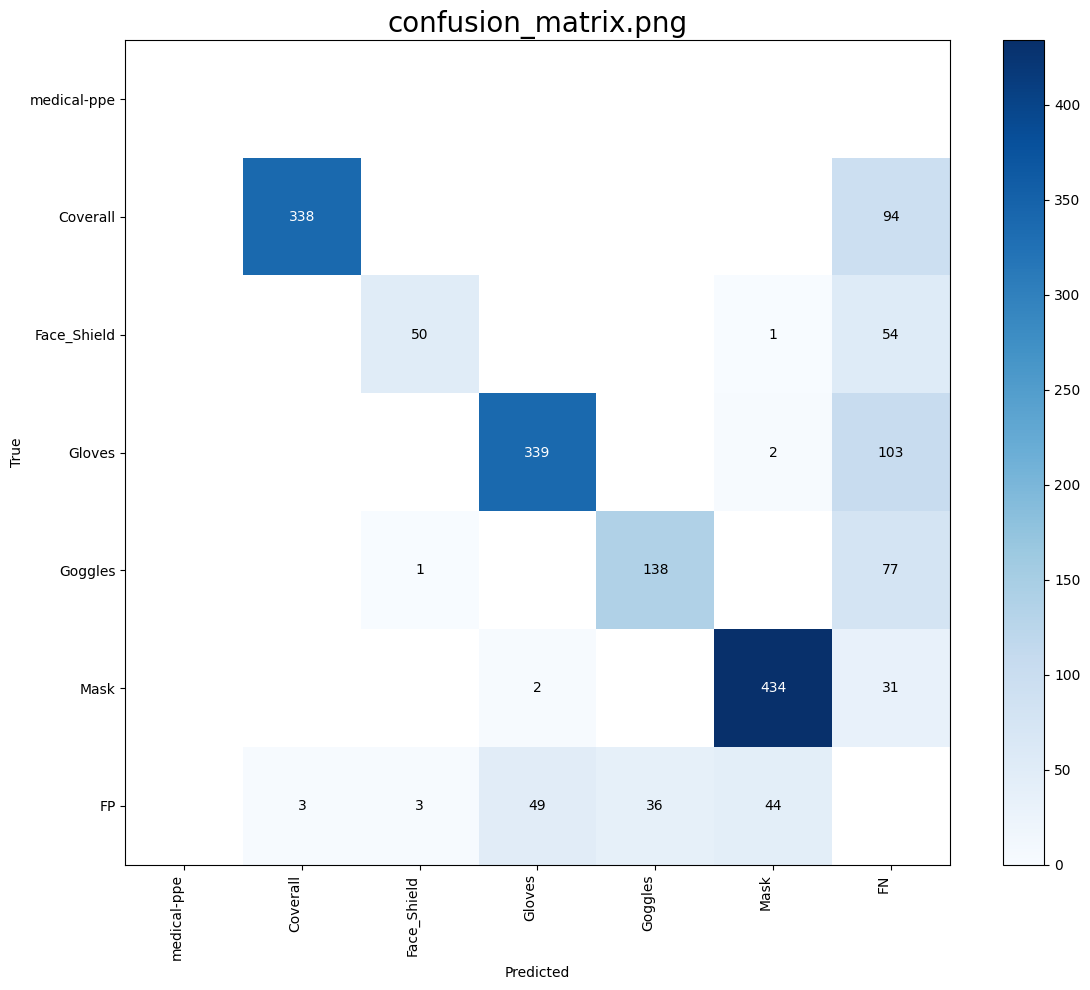

In [100]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot(save_path=f"./rtdetr-v2-L-mppe-{num}",title='confusion_matrix.png')

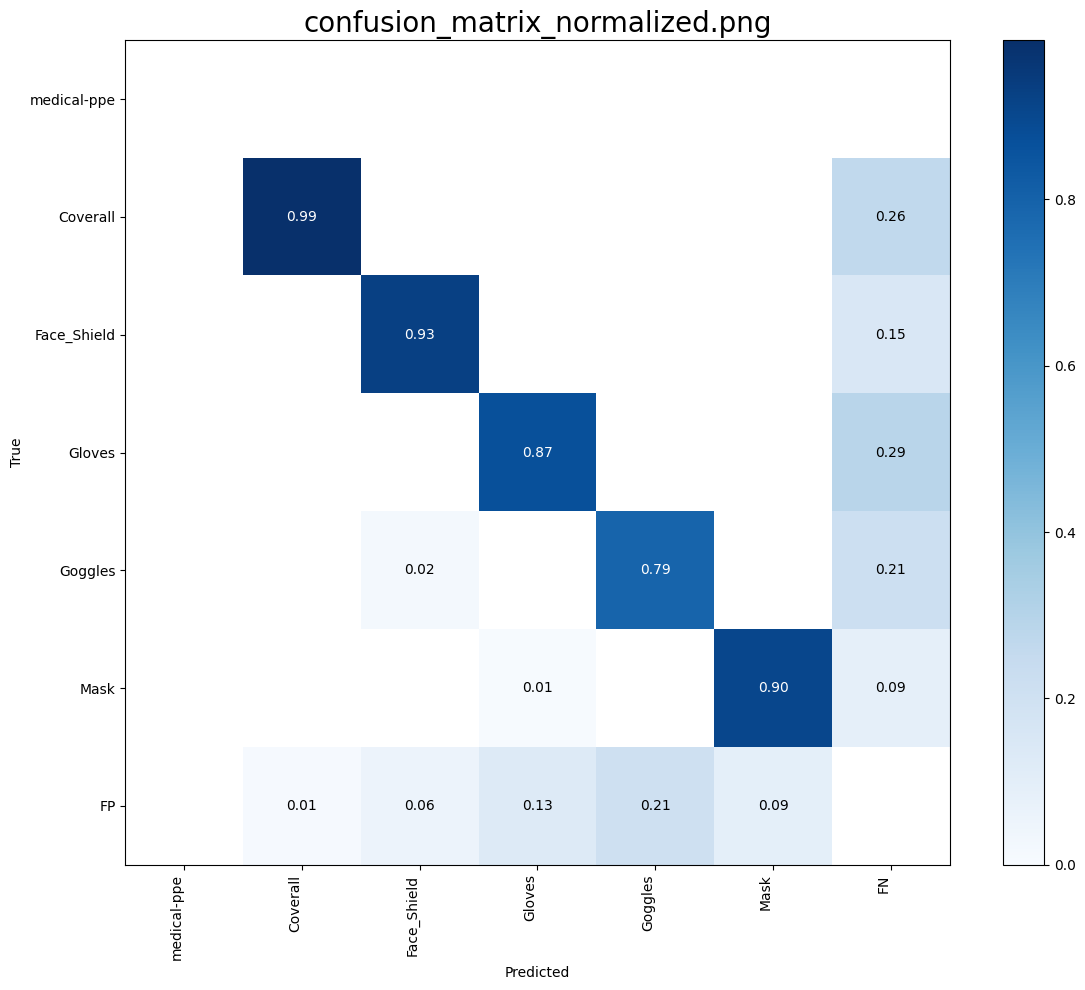

In [101]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot(normalize=True, save_path=f"./rtdetr-v2-L-mppe-{num}",title='confusion_matrix_normalized.png')

In [35]:
model.save_pretrained("./runs/rt-detr/")
processor.save_pretrained("./runs/rt-detr/")

['./runs/rt-detr/preprocessor_config.json']

In [22]:
def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

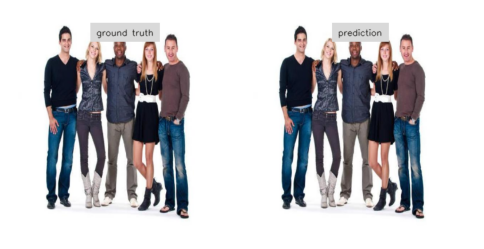

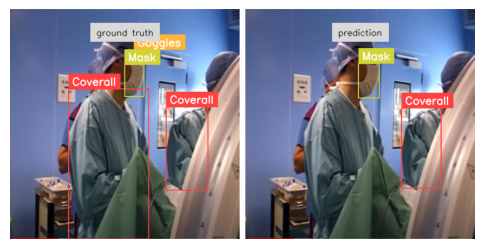

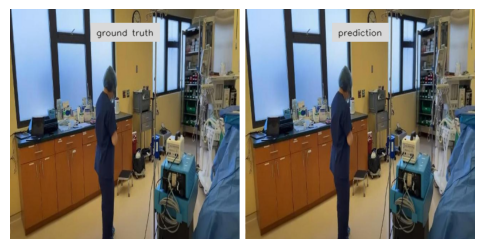

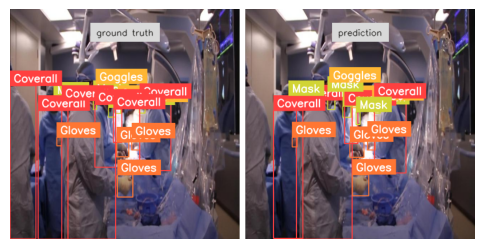

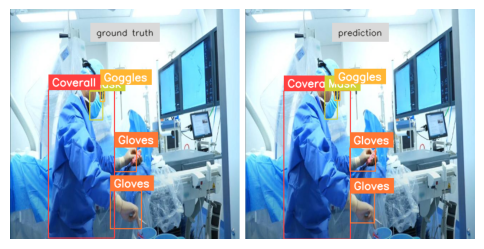

In [102]:
IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))